In [1]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow h5py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# pd.set_option('display.max_rows', None)
fp = "./features_combined.csv"
batch_pd = pd.read_csv(fp, index_col=False)
dataset = batch_pd.copy()
dataset.sort_values(by=['policy'], ascending=True, inplace=True)
dataset

,policy,barcode,cycle_life,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
41,1C_4PER_6C,???,300.0,1.070054,0.003530,1.038452,-0.868309,-1.146677,-2.745713,-0.310813,-0.054311,-3.862233,-0.000352,1.078732,-0.000647,1.104041,-2.743232
42,2C_10PER_6C,???,148.0,1.072070,0.001546,0.968339,-0.860038,-1.109668,-2.726901,-0.031052,-0.292914,-4.713663,-0.001088,1.084260,-0.001378,1.106627,-2.725386
43,2C_2PER_5C,???,438.0,1.073539,0.006428,1.075998,-1.263094,-1.610985,-3.493259,-0.769044,0.108508,-4.377028,-0.000012,1.078649,-0.000057,1.081674,-3.492122
44,2C_7PER_5_5C,???,335.0,1.066851,0.002059,1.046734,-0.996793,-1.246302,-2.929546,-0.374625,0.014785,-4.533756,-0.000225,1.072454,-0.000349,1.081733,-2.929246
0,3_6C-80PER_3_6C,???,1189.0,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-0.000210,1.091262,0.000039,1.072078,-5.013791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,8C-15PER_3_6C,???,965.0,1.083303,0.004503,1.085735,-1.536171,-1.898638,-4.055213,-0.604665,0.093945,-4.637046,-0.000008,1.087331,-0.000042,1.089934,-4.055273
38,8C-25PER_3_6C,???,650.0,1.068239,0.003432,1.068836,-1.350608,-1.717477,-3.667779,-0.624787,0.114815,-4.330611,-0.000024,1.071736,-0.000040,1.072816,-3.670995
37,8C-25PER_3_6C,???,701.0,1.079873,0.004960,1.083282,-1.349599,-1.686149,-3.665856,-0.967808,0.119336,-3.399592,0.000003,1.083766,-0.000036,1.086800,-3.670152
40,8C-35PER_3_6C,???,598.0,1.083956,0.004482,1.085828,-1.226188,-1.539612,-3.425292,-0.938556,0.107343,-3.975854,-0.000012,1.087803,-0.000037,1.089569,-3.425336


In [5]:
dataset.isna().sum()
dataset = dataset.dropna().drop(columns=['policy', 'barcode'])
dataset

,cycle_life,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
41,300.0,1.070054,0.003530,1.038452,-0.868309,-1.146677,-2.745713,-0.310813,-0.054311,-3.862233,-0.000352,1.078732,-0.000647,1.104041,-2.743232
42,148.0,1.072070,0.001546,0.968339,-0.860038,-1.109668,-2.726901,-0.031052,-0.292914,-4.713663,-0.001088,1.084260,-0.001378,1.106627,-2.725386
43,438.0,1.073539,0.006428,1.075998,-1.263094,-1.610985,-3.493259,-0.769044,0.108508,-4.377028,-0.000012,1.078649,-0.000057,1.081674,-3.492122
44,335.0,1.066851,0.002059,1.046734,-0.996793,-1.246302,-2.929546,-0.374625,0.014785,-4.533756,-0.000225,1.072454,-0.000349,1.081733,-2.929246
0,1189.0,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-0.000210,1.091262,0.000039,1.072078,-5.013791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,965.0,1.083303,0.004503,1.085735,-1.536171,-1.898638,-4.055213,-0.604665,0.093945,-4.637046,-0.000008,1.087331,-0.000042,1.089934,-4.055273
38,650.0,1.068239,0.003432,1.068836,-1.350608,-1.717477,-3.667779,-0.624787,0.114815,-4.330611,-0.000024,1.071736,-0.000040,1.072816,-3.670995
37,701.0,1.079873,0.004960,1.083282,-1.349599,-1.686149,-3.665856,-0.967808,0.119336,-3.399592,0.000003,1.083766,-0.000036,1.086800,-3.670152
40,598.0,1.083956,0.004482,1.085828,-1.226188,-1.539612,-3.425292,-0.938556,0.107343,-3.975854,-0.000012,1.087803,-0.000037,1.089569,-3.425336


## Data split

In [6]:
normal_charge_dataset = dataset.iloc[0:29, :]
fast_charge_dataset = dataset.iloc[29:, :]

## Normal Charge Test-Train split

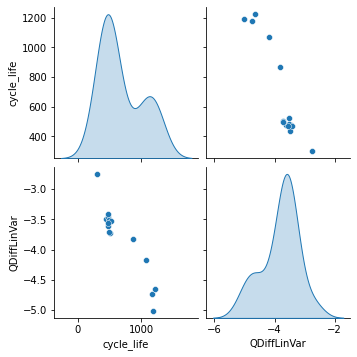

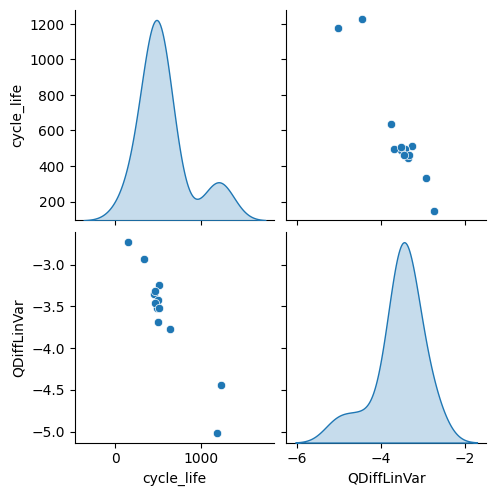

In [7]:
normal_charge_train_ds = normal_charge_dataset.iloc[0::2, :]
normal_charge_test_ds = normal_charge_dataset.iloc[1::2, :]
sns.pairplot(normal_charge_train_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
sns.pairplot(normal_charge_test_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')

In [8]:
normal_charge_train_ds.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
cycle_life,15.0,678.733333,326.411543,300.000000,474.000000,498.000000,971.000000,1226.000000
QD2,15.0,1.074585,0.007457,1.063838,1.070372,1.073539,1.077529,1.093864
QD(Max-2),15.0,0.036268,0.119544,0.003530,0.004164,0.005900,0.006409,0.468365
QD100,15.0,1.074448,0.013190,1.038452,1.070632,1.075998,1.081213,1.095762
QDiffMin,15.0,-1.414431,0.297163,-2.072648,-1.508261,-1.317857,-1.259662,-0.868309
QDiffMean,15.0,-1.772270,0.360231,-2.541602,-1.867198,-1.653251,-1.569754,-1.146677
QDiffVar,15.0,-3.809938,0.594486,-5.014861,-3.996182,-3.602695,-3.509759,-2.745713
QDiffSkew,15.0,-0.705178,0.364792,-1.125730,-1.048717,-0.769044,-0.458824,0.033502
QDiffKurtosis,15.0,0.042687,0.147784,-0.457627,0.042620,0.089031,0.112996,0.134323
QDiffStart,15.0,-4.206406,0.527930,-5.056484,-4.531912,-4.261444,-3.676504,-3.569522


In [9]:
normalcharge_train_features = normal_charge_train_ds.copy()
normalcharge_test_features = normal_charge_test_ds.copy()

train_labels = normalcharge_train_features.pop('cycle_life')
test_labels = normalcharge_test_features.pop('cycle_life')


## Normalization Layer

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(normalcharge_train_features))
print(normalizer.mean.numpy())

[[ 1.0745854e+00  3.6268070e-02  1.0744476e+00 -1.4144307e+00
  -1.7722696e+00 -3.8099389e+00 -7.0517755e-01  4.2686757e-02
  -4.2064056e+00 -4.8761252e-05  1.0803745e+00 -1.0708744e-04
   1.0851731e+00 -3.8086476e+00]]


2022-07-10 16:49:00.445265: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Linear Regress
## Layering

In [11]:
QDiffLinVar = np.array(normalcharge_train_features['QDiffLinVar'])
QDiffLinVar_normalizer = layers.Normalization(input_shape=[1,], axis=None)
QDiffLinVar_normalizer.adapt(QDiffLinVar)

## Model Building

In [12]:
variance_model_normal_charge = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

variance_model_normal_charge.summary()
print("Number of weights after calling the model:", len(variance_model_normal_charge.weights))
print("weights:", len(variance_model_normal_charge.weights))
print("trainable_weights:", len(variance_model_normal_charge.trainable_weights))
print("non_trainable_weights:", len(variance_model_normal_charge.non_trainable_weights))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________
Number of weights after calling the model: 9
weights: 9
trainable_weights: 6
non_trainable_weights: 3


In [13]:
variance_model_normal_charge.predict(QDiffLinVar[:10])

array([[-0.0129941 ],
       [-0.00386044],
       [ 0.05583671],
       [ 0.04289094],
       [-0.00247379],
       [ 0.03863749],
       [-0.00421697],
       [ 0.01694659],
       [-0.00354963],
       [-0.0011046 ]], dtype=float32)

In [14]:
variance_model_normal_charge.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
    )

In [15]:
%%time
history = variance_model_normal_charge.fit(
    normalcharge_train_features['QDiffLinVar'],
    train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/1000
1/1 [==============================] - 0s 463ms/step - loss: 642716.5625 - mae: 728.6564 - val_loss: 229464.9219 - val_mae: 478.8339
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 642125.5625 - mae: 728.3228 - val_loss: 229310.8750 - val_mae: 478.6721
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 641557.8750 - mae: 728.0030 - val_loss: 229133.2031 - val_mae: 478.4858
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 640962.3750 - mae: 727.6628 - val_loss: 228915.1719 - val_mae: 478.2572
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 640267.5625 - mae: 727.2619 - val_loss: 228646.2969 - val_mae: 477.9754
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 639441.2500 - mae: 726.7817 - val_loss: 228320.2031 - val_mae: 477.6336
Epoch 7/1000
1/1 [==============================] - 0s 21ms/step - loss: 638450.9375 - mae: 726.2057 - val_loss: 227924.6406 - va

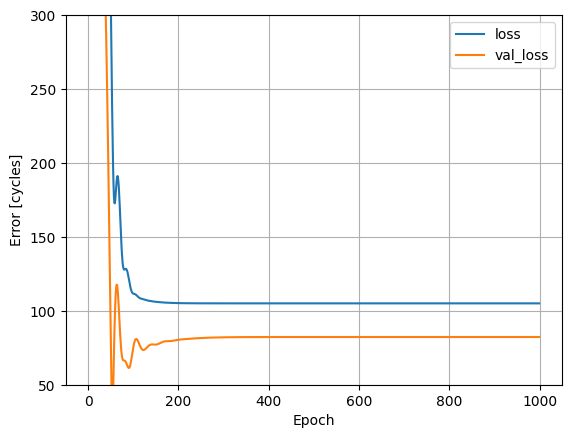

In [16]:
def plot_loss(history):
  plt.plot(np.sqrt(history.history['loss']), label='loss')
  plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
  # plt.ylim([200, 130])
  plt.ylim([50, 300])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [17]:
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist


,loss,mae,val_loss,val_mae,epoch
0,801.696054,26.993637,479.024970,21.882273,0
1,801.327375,26.987455,478.864151,21.878577,1
2,800.973080,26.981531,478.678601,21.874319,2
3,800.601258,26.975225,478.450804,21.869093,3
4,800.167209,26.967794,478.169736,21.862649,4
...,...,...,...,...,...
995,105.033249,8.895031,82.271930,8.381263,995
996,105.033249,8.895031,82.271903,8.381262,996
997,105.033249,8.895031,82.271903,8.381262,997
998,105.033249,8.895031,82.271903,8.381262,998


In [18]:
test_results = {}

test_results['normal_charge_variance_model'] = variance_model_normal_charge.evaluate(
    normalcharge_test_features['QDiffLinVar'],
    test_labels, verbose=1) #sqrt for mse

1/1 [==============================] - 0s 20ms/step - loss: 9642.4424 - mae: 73.2446


## Predict

15 14


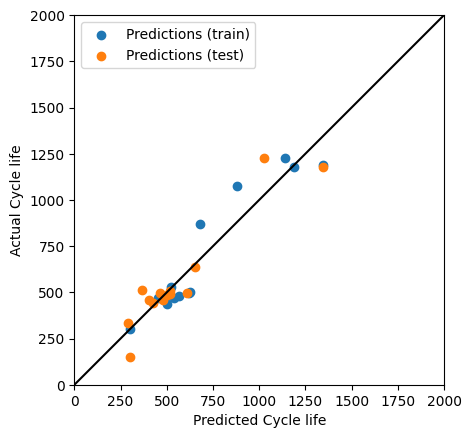

In [19]:
def plot_prediction(y_train, y_test):
  plt.axes(aspect='equal')
  plt.scatter(y_train, train_labels, label='Predictions (train)')
  plt.scatter(y_test, test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

train_prediction = variance_model_normal_charge.predict(normal_charge_train_ds['QDiffLinVar'])
test_prediction = variance_model_normal_charge.predict(normal_charge_test_ds['QDiffLinVar'])
plot_prediction(train_prediction, test_prediction)
print(train_prediction.size, test_prediction.size)

In [20]:
print("weights:", len(variance_model_normal_charge.weights))
print("trainable_weights:", len(variance_model_normal_charge.trainable_weights))
print("non_trainable_weights:", len(variance_model_normal_charge.non_trainable_weights))


weights: 9
trainable_weights: 6
non_trainable_weights: 3


In [21]:
test_results['normal_charge_variance_model'][0] = test_results['normal_charge_variance_model'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'Mean absolute error']).T

,MSE,Mean absolute error
normal_charge_variance_model,98.195939,73.244576


In [22]:
variance_model_normal_charge.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


# Transfer Learning

### Model Building
Freeze last layer for TF

In [23]:
variance_model_fast_charge_tl = variance_model_normal_charge

In [24]:
for layer in variance_model_fast_charge_tl.layers[:-1]:
  layer.trainable = False

### Creating new model on top

In [25]:
variance_model_fast_charge_tl.add(layers.Dense(64, activation="relu"))
variance_model_fast_charge_tl.add(layers.Dense(64, activation="relu"))
variance_model_fast_charge_tl.add(layers.Dense(1))
variance_model_fast_charge_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 dense_3 (Dense)             (None, 64)                128       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                        

### Fast-charge Data Train-Test split

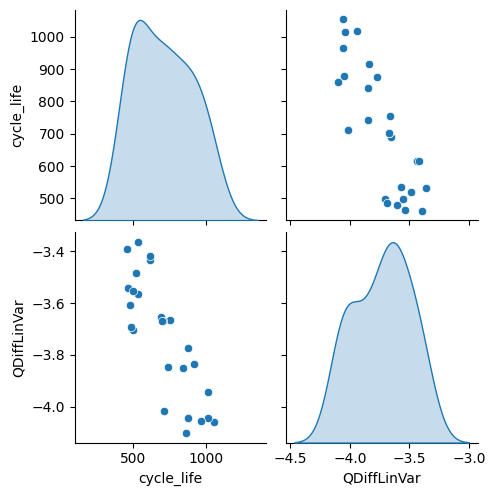

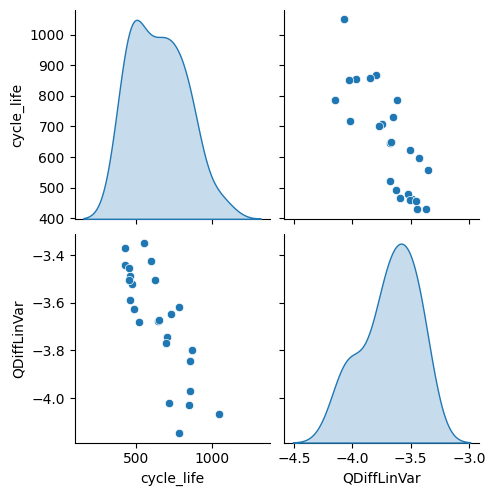

In [26]:
fast_charge_train_ds = fast_charge_dataset.iloc[0::2, :]
fast_charge_test_ds = fast_charge_dataset.iloc[1::2, :]
sns.pairplot(fast_charge_train_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
sns.pairplot(fast_charge_test_ds[['cycle_life', 'QDiffLinVar']], diag_kind='kde')
# fast_charge_test_ds

In [27]:
fastcharge_train_features = fast_charge_train_ds.copy()
fastcharge_test_features = fast_charge_test_ds.copy()

fast_train_labels = fastcharge_train_features.pop('cycle_life')
fast_test_labels = fastcharge_test_features.pop('cycle_life')


### Compile and fit

In [28]:
variance_model_fast_charge_traditional = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
variance_model_fast_charge_traditional.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
    )
variance_model_fast_charge_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
    )

In [29]:
%%time
history_tl = variance_model_fast_charge_tl.fit(
    fastcharge_train_features['QDiffLinVar'],
    fast_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/1000
1/1 [==============================] - 0s 470ms/step - loss: 474775.5000 - mae: 659.5575 - val_loss: 282012.6562 - val_mae: 524.9474
Epoch 2/1000
1/1 [==============================] - 0s 21ms/step - loss: 275071.3750 - mae: 494.7708 - val_loss: 157924.6094 - val_mae: 393.1510
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 150231.9062 - mae: 355.4566 - val_loss: 69787.8281 - val_mae: 260.9190
Epoch 4/1000
1/1 [==============================] - 0s 22ms/step - loss: 65490.0820 - mae: 215.6827 - val_loss: 16528.7793 - val_mae: 122.4357
Epoch 5/1000
1/1 [==============================] - 0s 21ms/step - loss: 20241.2246 - mae: 116.9727 - val_loss: 3996.5627 - val_mae: 54.9102
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 21659.0195 - mae: 117.6821 - val_loss: 26411.8691 - val_mae: 143.9781
Epoch 7/1000
1/1 [==============================] - 0s 21ms/step - loss: 58346.6484 - mae: 212.3036 - val_loss: 42957.9141 - val_mae: 189.

In [30]:
%%time
history_traditional = variance_model_fast_charge_traditional.fit(
    fastcharge_train_features['QDiffLinVar'],
    fast_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/1000
1/1 [==============================] - 0s 480ms/step - loss: 539300.1250 - mae: 704.6962 - val_loss: 537040.9375 - val_mae: 723.3434
Epoch 2/1000
1/1 [==============================] - 0s 24ms/step - loss: 539038.0000 - mae: 704.4957 - val_loss: 536764.0000 - val_mae: 723.1457
Epoch 3/1000
1/1 [==============================] - 0s 26ms/step - loss: 538793.3125 - mae: 704.3116 - val_loss: 536439.9375 - val_mae: 722.9150
Epoch 4/1000
1/1 [==============================] - 0s 27ms/step - loss: 538502.1250 - mae: 704.0944 - val_loss: 536047.2500 - val_mae: 722.6365
Epoch 5/1000
1/1 [==============================] - 0s 29ms/step - loss: 538144.2500 - mae: 703.8301 - val_loss: 535566.1875 - val_mae: 722.2967
Epoch 6/1000
1/1 [==============================] - 0s 29ms/step - loss: 537702.5000 - mae: 703.5059 - val_loss: 534971.3750 - val_mae: 721.8765
Epoch 7/1000
1/1 [==============================] - 0s 28ms/step - loss: 537154.8750 - mae: 703.1040 - val_loss: 534240.6875 - va

### Plot loss graph

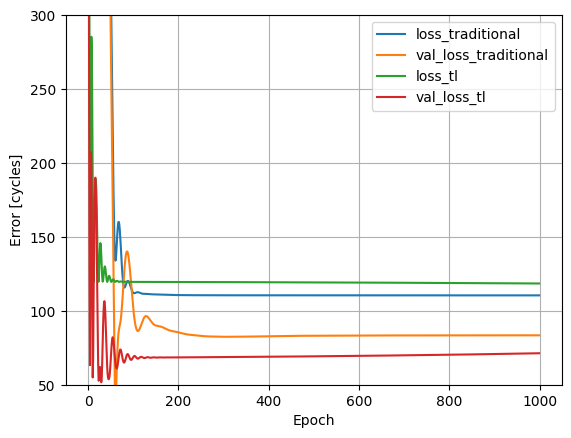

In [39]:
def plot_loss(hist_trad, hist_tl):
  plt.plot(np.sqrt(hist_trad.history['loss']), label='loss_traditional')
  plt.plot(np.sqrt(hist_trad.history['val_loss']), label='val_loss_traditional')
  plt.plot(np.sqrt(hist_tl.history['loss']), label='loss_tl')
  plt.plot(np.sqrt(hist_tl.history['val_loss']), label='val_loss_tl')
  # plt.ylim([200, 130])
  plt.ylim([50, 300])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)

plot_loss(history_traditional, history_tl)

In [32]:
hist = pd.DataFrame(history_tl.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist



,loss,mae,val_loss,val_mae,epoch
0,689.039549,25.681851,531.048638,22.911730,0
1,524.472473,22.243443,397.397294,19.828037,1
2,387.597609,18.853557,264.173860,16.152987,2
3,255.910301,14.686140,128.564300,11.065066,3
4,142.271658,10.815393,63.218373,7.410144,4
...,...,...,...,...,...
995,118.484300,10.242236,71.265551,8.005740,995
996,118.482355,10.242147,71.271337,8.006005,996
997,118.480442,10.242058,71.277136,8.006269,997
998,118.478547,10.241971,71.282976,8.006535,998


In [33]:
hist2 = pd.DataFrame(history_traditional.history)
hist2 = hist.pow(0.5)
hist2['epoch'] = history_traditional.epoch
hist2

,loss,mae,val_loss,val_mae,epoch
0,26.249563,5.067726,23.044493,4.786620,0
1,22.901364,4.716295,19.934826,4.452868,1
2,19.687499,4.342068,16.253426,4.019078,2
3,15.997197,3.832250,11.338620,3.326419,3
4,11.927768,3.288676,7.950998,2.722158,4
...,...,...,...,...,...
995,10.885049,3.200349,8.441893,2.829442,995
996,10.884960,3.200335,8.442235,2.829489,996
997,10.884872,3.200322,8.442579,2.829535,997
998,10.884785,3.200308,8.442925,2.829582,998


In [34]:
test_results['fast_charge_variance_model_tl'] = variance_model_fast_charge_tl.evaluate(
    fastcharge_test_features['QDiffLinVar'],
    fast_test_labels, verbose=1) #sqrt for mse
test_results['fast_charge_variance_model_traditional'] = variance_model_fast_charge_traditional.evaluate(
    fastcharge_test_features['QDiffLinVar'],
    fast_test_labels, verbose=1) #sqrt for mse

1/1 [==============================] - 0s 23ms/step - loss: 11060.5127 - mae: 85.5255


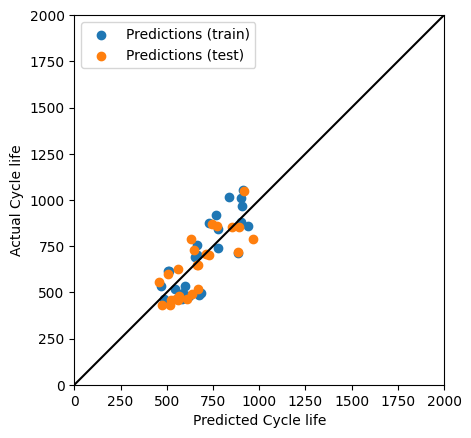

In [35]:
def plot_prediction(y_train, y_test):
  plt.axes(aspect='equal')
  plt.scatter(y_train, fast_train_labels, label='Predictions (train)')
  plt.scatter(y_test, fast_test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()

fast_train_prediction = variance_model_fast_charge_tl.predict(fast_charge_train_ds['QDiffLinVar'])
fast_test_prediction = variance_model_fast_charge_tl.predict(fast_charge_test_ds['QDiffLinVar'])
plot_prediction(fast_train_prediction, fast_test_prediction)



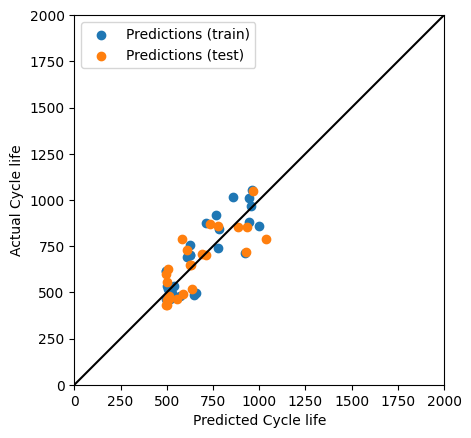

In [36]:
fast_train_prediction2 = variance_model_fast_charge_traditional.predict(fast_charge_train_ds['QDiffLinVar'])
fast_test_prediction2 = variance_model_fast_charge_traditional.predict(fast_charge_test_ds['QDiffLinVar'])
plot_prediction(fast_train_prediction2, fast_test_prediction2)

In [37]:
test_results['fast_charge_variance_model_tl'][0] = test_results['fast_charge_variance_model_tl'][0] ** 0.5
test_results['fast_charge_variance_model_traditional'][0] = test_results['fast_charge_variance_model_traditional'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'Mean absolute error']).T

,MSE,Mean absolute error
normal_charge_variance_model,98.195939,73.244576
fast_charge_variance_model_tl,101.959201,87.743240
fast_charge_variance_model_traditional,105.168972,85.525467


# Scratch Test

In [38]:
# model = tf.keras.Sequential(
#     [
#         layers.Dense(2, activation="relu"),
#         layers.Dense(3, activation="relu"),
#         layers.Dense(4),
#     ]
# ) 
# model.summary()